Download data

In [1]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip
!ls

--2020-11-10 03:48:54--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.32.204.49, 13.32.204.34, 13.32.204.65, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.32.204.49|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip.1’

data.zip.1          100%[===================>]   2.75M  --.-KB/s    in 0.05s   

2020-11-10 03:48:54 (50.5 MB/s) - ‘data.zip.1’ saved [2882130/2882130]

Archive:  data.zip
replace data/eng-fra.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
char_rnn_generation_model2.pt  char_rnn_generation_model.pt  data.zip.1
char_rnn_generation_model3.pt  data			     sample_data
char_rnn_generation_model4.pt  data.zip


In [2]:
%matplotlib inline


Generating Names with a Character-Level RNN
*******************************************
**Author**: `Sean Robertson <https://github.com/spro/practical-pytorch>`_

In the :doc:`last tutorial </intermediate/char_rnn_classification_tutorial>`
we used a RNN to classify names into their language of origin. This time
we'll turn around and generate names from languages.

::

    > python sample.py Russian RUS
    Rovakov
    Uantov
    Shavakov

    > python sample.py German GER
    Gerren
    Ereng
    Rosher

    > python sample.py Spanish SPA
    Salla
    Parer
    Allan

    > python sample.py Chinese CHI
    Chan
    Hang
    Iun

We are still hand-crafting a small RNN with a few linear layers. The big
difference is instead of predicting a category after reading in all the
letters of a name, we input a category and output one letter at a time.
Recurrently predicting characters to form language (this could also be
done with words or other higher order constructs) is often referred to
as a "language model".

**Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-  http://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

-  `The Unreasonable Effectiveness of Recurrent Neural
   Networks <http://karpathy.github.io/2015/05/21/rnn-effectiveness/>`__
   shows a bunch of real life examples
-  `Understanding LSTM
   Networks <http://colah.github.io/posts/2015-08-Understanding-LSTMs/>`__
   is about LSTMs specifically but also informative about RNNs in
   general

I also suggest the previous tutorial, :doc:`/intermediate/char_rnn_classification_tutorial`


Preparing the Data
==================

.. Note::
   Download the data from
   `here <https://download.pytorch.org/tutorial/data.zip>`_
   and extract it to the current directory.

See the last tutorial for more detail of this process. In short, there
are a bunch of plain text files ``data/names/[Language].txt`` with a
name per line. We split lines into an array, convert Unicode to ASCII,
and end up with a dictionary ``{language: [names ...]}``.




In [3]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import math
import random

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
train_data = {}
validation_data = {}
test_data = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    random.shuffle(lines)
    train_data[category] = lines[0:int(math.floor(0.7*len(lines)))]
    validation_data[category] = lines[int(math.floor(0.7*len(lines)))+1:int(math.floor(0.85*len(lines)))]
    test_data[category] = lines[int(math.floor(0.85*len(lines)))+1:]
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Italian', 'Korean', 'Czech', 'English', 'French', 'Vietnamese', 'Arabic', 'Russian', 'Greek', 'Dutch', 'German', 'Japanese', 'Spanish', 'Polish', 'Scottish', 'Chinese', 'Portuguese', 'Irish']
O'Neal




```
# This is formatted as code
```

Creating the Network i
====================

This network extends `the last tutorial's RNN <#Creating-the-Network>`__
with an extra argument for the category tensor, which is concatenated
along with the others. The category tensor is a one-hot vector just like
the letter input.

We will interpret the output as the probability of the next letter. When
sampling, the most likely output letter is used as the next input
letter.

I added a second linear layer ``o2o`` (after combining hidden and
output) to give it more muscle to work with. There's also a dropout
layer, which `randomly zeros parts of its
input <https://arxiv.org/abs/1207.0580>`__ with a given probability
(here 0.1) and is usually used to fuzz inputs to prevent overfitting.
Here we're using it towards the end of the network to purposely add some
chaos and increase sampling variety.

.. figure:: https://i.imgur.com/jzVrf7f.png
   :alt:





In [4]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN1(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN1, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

Training
=========
Preparing for Training
----------------------

First of all, helper functions to get random pairs of (category, line):




In [5]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(train_data[category])
    return category, line

For each timestep (that is, for each letter in a training word) the
inputs of the network will be
``(category, current letter, hidden state)`` and the outputs will be
``(next letter, next hidden state)``. So for each training set, we'll
need the category, a set of input letters, and a set of output/target
letters.

Since we are predicting the next letter from the current letter for each
timestep, the letter pairs are groups of consecutive letters from the
line - e.g. for ``"ABCD<EOS>"`` we would create ("A", "B"), ("B", "C"),
("C", "D"), ("D", "EOS").

.. figure:: https://i.imgur.com/JH58tXY.png
   :alt:

The category tensor is a `one-hot
tensor <https://en.wikipedia.org/wiki/One-hot>`__ of size
``<1 x n_categories>``. When training we feed it to the network at every
timestep - this is a design choice, it could have been included as part
of initial hidden state or some other strategy.




In [6]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

For convenience during training we'll make a ``randomTrainingExample``
function that fetches a random (category, line) pair and turns them into
the required (category, input, target) tensors.




In [7]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

Training the Network i
--------------------

In contrast to classification, where only the last output is used, we
are making a prediction at every step, so we are calculating loss at
every step.

The magic of autograd allows you to simply sum these losses at each step
and call backward at the end.




In [8]:
criterion = nn.NLLLoss()

def train1(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    # compute the gradient by backpropagation
    loss.backward()

    # update the parameters
    optimizer.step()

    return output, loss.item() / input_line_tensor.size(0)

To keep track of how long training takes I am adding a
``timeSince(timestamp)`` function which returns a human readable string:




In [9]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [10]:
rnn = RNN1(n_letters, 128, n_letters)
optimizer = torch.optim.Adam(rnn.parameters())


n_iters = 40000
print_every = 2500
plot_every = 500
all_train_losses_i = []
all_validation_losses_i = []
train_loss = 0 # Reset every plot_every iters

# Just return an output given a line
def evaluate1(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()
    loss = 0
    for i in range(input_line_tensor.size()[0]):
      output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
      loss += criterion(output, target_line_tensor[i])
    return output, loss.item() / input_line_tensor.size(0)

def eval_dataset1(dataset):
    total_loss = 0
    n_instances = 0
    for category in all_categories:
        category_tensor = Variable(categoryTensor(category))
        n_instances += len(dataset[category])
        for line in dataset[category]:
            input_line_tensor = Variable(inputTensor(line))
            target_line_tensor = Variable(targetTensor(line))
            output, loss = evaluate1(category_tensor, input_line_tensor, target_line_tensor)
            total_loss += loss
    return total_loss / n_instances

start = time.time()
print('\nIter_i \tTrain% \tTime \t\tTrain_loss')
for iter in range(1, n_iters + 1):
    output, loss = train1(*randomTrainingExample())
    train_loss += loss

    if iter % print_every == 0:
        print('%d \t%d%% \t(%s) \t%.4f' % (iter, iter / n_iters * 100, timeSince(start), train_loss / plot_every))

    if iter % plot_every == 0:
        all_train_losses_i.append(train_loss / plot_every)
        train_loss = 0
        
    # Compute loss based on validation data
    if iter % plot_every == 0:
        average_validation_loss = eval_dataset1(validation_data)

        # save model with best validation loss
        if len(all_validation_losses_i) == 0 or average_validation_loss < min(all_validation_losses_i):
            torch.save(rnn, 'char_rnn_generation_model.pt')
        all_validation_losses_i.append(average_validation_loss)


Iter_i 	Train% 	Time 		Train_loss
2500 	6% 	(0m 30s) 	2.4517
5000 	12% 	(1m 5s) 	2.2959
7500 	18% 	(1m 41s) 	2.2982
10000 	25% 	(2m 17s) 	2.2924
12500 	31% 	(2m 52s) 	2.2958
15000 	37% 	(3m 27s) 	2.2466
17500 	43% 	(4m 2s) 	2.2157
20000 	50% 	(4m 38s) 	2.2684
22500 	56% 	(5m 14s) 	2.2450
25000 	62% 	(5m 49s) 	2.2837
27500 	68% 	(6m 23s) 	2.2509
30000 	75% 	(6m 57s) 	2.2288
32500 	81% 	(7m 30s) 	2.2303
35000 	87% 	(8m 2s) 	2.2598
37500 	93% 	(8m 34s) 	2.2084
40000 	100% 	(9m 5s) 	2.1824


# Creating the Network ii


In [11]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN2, self).__init__()
        self.hidden_size = hidden_size

        self.i2h_withCat = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2h = nn.Linear( input_size + hidden_size, hidden_size)
        self.i2o_withCat = nn.Linear(n_categories+input_size + hidden_size, output_size)
        self.i2o = nn.Linear( input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def forwardWithCat(self, category, input, hidden):
        input_combined = torch.cat((category,input, hidden), 1)
        hidden = self.i2h_withCat(input_combined)
        output = self.i2o_withCat(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

# Training the Network ii

In [12]:
criterion = nn.NLLLoss()

def train2(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        if i==0:
          output, hidden = rnn.forwardWithCat(category_tensor, input_line_tensor[i], hidden)
        else:
          output, hidden = rnn.forward(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    # compute the gradient by backpropagation
    loss.backward()

    # update the parameters
    optimizer.step()

    return output, loss.item() / input_line_tensor.size(0)

In [13]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [14]:
rnn = RNN2(n_letters, 128, n_letters)
optimizer = torch.optim.Adam(rnn.parameters())



n_iters = 40000
print_every = 2500
plot_every = 500
all_train_losses_ii = []
all_validation_losses_ii = []
train_loss = 0 # Reset every plot_every iters

# Just return an output given a line
def evaluate2(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()
    loss = 0
    for i in range(input_line_tensor.size()[0]):
      if i==0:
        output, hidden = rnn.forwardWithCat(category_tensor, input_line_tensor[i], hidden)
      else:
        output, hidden = rnn.forward(category_tensor, input_line_tensor[i], hidden)
      loss += criterion(output, target_line_tensor[i])
    return output, loss.item() / input_line_tensor.size(0)

def eval_dataset2(dataset):
    total_loss = 0
    n_instances = 0
    for category in all_categories:
        category_tensor = Variable(categoryTensor(category))
        n_instances += len(dataset[category])
        for line in dataset[category]:
            input_line_tensor = Variable(inputTensor(line))
            target_line_tensor = Variable(targetTensor(line))
            output, loss = evaluate2(category_tensor, input_line_tensor, target_line_tensor)
            total_loss += loss
    return total_loss / n_instances

start = time.time()
print('\nIter_ii \tTrain% \tTime \t\tTrain_loss')
for iter in range(1, n_iters + 1):
    output, loss = train2(*randomTrainingExample())
    train_loss += loss

    if iter % print_every == 0:
        print('%d \t%d%% \t(%s) \t%.4f' % (iter, iter / n_iters * 100, timeSince(start), train_loss / plot_every))

    if iter % plot_every == 0:
        all_train_losses_ii.append(train_loss / plot_every)
        train_loss = 0
        
    # Compute loss based on validation data
    if iter % plot_every == 0:
        average_validation_loss = eval_dataset2(validation_data)

        # save model with best validation loss
        if len(all_validation_losses_ii) == 0 or average_validation_loss < min(all_validation_losses_ii):
            torch.save(rnn, 'char_rnn_generation_model2.pt')
        all_validation_losses_ii.append(average_validation_loss)


Iter_ii 	Train% 	Time 		Train_loss
2500 	6% 	(0m 27s) 	2.4649
5000 	12% 	(0m 59s) 	2.3683
7500 	18% 	(1m 32s) 	2.3111
10000 	25% 	(2m 5s) 	2.3361
12500 	31% 	(2m 36s) 	2.3333
15000 	37% 	(3m 7s) 	2.2786
17500 	43% 	(3m 38s) 	2.2597
20000 	50% 	(4m 9s) 	2.2828
22500 	56% 	(4m 40s) 	2.2492
25000 	62% 	(5m 11s) 	2.2157
27500 	68% 	(5m 42s) 	2.1979
30000 	75% 	(6m 14s) 	2.1746
32500 	81% 	(6m 44s) 	2.2124
35000 	87% 	(7m 14s) 	2.2230
37500 	93% 	(7m 44s) 	2.1898
40000 	100% 	(8m 15s) 	2.1804


# Creating the Network iii


In [15]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN3(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN3, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories  + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories  + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

# Training the Network iii


In [16]:
criterion = nn.NLLLoss()

def train3(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    # compute the gradient by backpropagation
    loss.backward()

    # update the parameters
    optimizer.step()

    return output, loss.item() / input_line_tensor.size(0)

In [17]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [18]:
rnn = RNN3(n_letters, 128, n_letters)
optimizer = torch.optim.Adam(rnn.parameters())


n_iters = 40000
print_every = 2500
plot_every = 500
all_train_losses_iii = []
all_validation_losses_iii = []
train_loss = 0 # Reset every plot_every iters

# Just return an output given a line
def evaluate3(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()
    loss = 0
    for i in range(input_line_tensor.size()[0]):
      output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
      loss += criterion(output, target_line_tensor[i])
    return output, loss.item() / input_line_tensor.size(0)

def eval_dataset3(dataset):
    total_loss = 0
    n_instances = 0
    for category in all_categories:
        category_tensor = Variable(categoryTensor(category))
        n_instances += len(dataset[category])
        for line in dataset[category]:
            input_line_tensor = Variable(inputTensor(line))
            target_line_tensor = Variable(targetTensor(line))
            output, loss = evaluate3(category_tensor, input_line_tensor, target_line_tensor)
            total_loss += loss
    return total_loss / n_instances

start = time.time()
print('\nIter \tTrain% \tTime \t\tTrain_loss')
for iter in range(1, n_iters + 1):
    output, loss = train3(*randomTrainingExample())
    train_loss += loss

    if iter % print_every == 0:
        print('%d \t%d%% \t(%s) \t%.4f' % (iter, iter / n_iters * 100, timeSince(start), train_loss / plot_every))

    if iter % plot_every == 0:
        all_train_losses_iii.append(train_loss / plot_every)
        train_loss = 0
        
    # Compute loss based on validation data
    if iter % plot_every == 0:
        average_validation_loss = eval_dataset3(validation_data)

        # save model with best validation loss
        if len(all_validation_losses_iii) == 0 or average_validation_loss < min(all_validation_losses_iii):
            torch.save(rnn, 'char_rnn_generation_model3.pt')
        all_validation_losses_iii.append(average_validation_loss)


Iter 	Train% 	Time 		Train_loss
2500 	6% 	(0m 24s) 	2.7343
5000 	12% 	(0m 52s) 	2.6539
7500 	18% 	(1m 20s) 	2.6722
10000 	25% 	(1m 49s) 	2.6397
12500 	31% 	(2m 17s) 	2.6378
15000 	37% 	(2m 45s) 	2.6300
17500 	43% 	(3m 14s) 	2.6396
20000 	50% 	(3m 42s) 	2.6077
22500 	56% 	(4m 12s) 	2.6532
25000 	62% 	(4m 40s) 	2.6536
27500 	68% 	(5m 8s) 	2.6213
30000 	75% 	(5m 37s) 	2.6124
32500 	81% 	(6m 5s) 	2.6247
35000 	87% 	(6m 33s) 	2.6067
37500 	93% 	(7m 2s) 	2.6316
40000 	100% 	(7m 30s) 	2.6423


# Creating the Network iv


In [19]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN4(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN4, self).__init__()
        self.hidden_size = hidden_size

        self.i2h_withCat = nn.Linear(n_categories + hidden_size, hidden_size)
        self.i2h = nn.Linear( hidden_size, hidden_size)
        self.i2o_withCat = nn.Linear(n_categories + hidden_size, output_size)
        self.i2o = nn.Linear( hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = hidden
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def forwardWithCat(self, category, input, hidden):
        input_combined = torch.cat((category, hidden), 1)
        hidden = self.i2h_withCat(input_combined)
        output = self.i2o_withCat(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

# Training the Network iv


In [20]:
criterion = nn.NLLLoss()

def train4(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        if i==0:
          output, hidden = rnn.forwardWithCat(category_tensor, input_line_tensor[i], hidden)
        else:
          output, hidden = rnn.forward(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    # compute the gradient by backpropagation
    loss.backward()

    # update the parameters
    optimizer.step()

    return output, loss.item() / input_line_tensor.size(0)

In [21]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [22]:
rnn = RNN4(n_letters, 128, n_letters)
optimizer = torch.optim.Adam(rnn.parameters())

n_iters = 40000
print_every = 2500
plot_every = 500
all_train_losses_iv = []
all_validation_losses_iv = []
train_loss = 0 # Reset every plot_every iters

# Just return an output given a line
def evaluate4(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()
    loss = 0
    for i in range(input_line_tensor.size()[0]):
      if i==0:
        output, hidden = rnn.forwardWithCat(category_tensor, input_line_tensor[i], hidden)
      else:
        output, hidden = rnn.forward(category_tensor, input_line_tensor[i], hidden)
      loss += criterion(output, target_line_tensor[i])
    return output, loss.item() / input_line_tensor.size(0)

def eval_dataset4(dataset):
    total_loss = 0
    n_instances = 0
    for category in all_categories:
        category_tensor = Variable(categoryTensor(category))
        n_instances += len(dataset[category])
        for line in dataset[category]:
            input_line_tensor = Variable(inputTensor(line))
            target_line_tensor = Variable(targetTensor(line))
            output, loss = evaluate4(category_tensor, input_line_tensor, target_line_tensor)
            total_loss += loss
    return total_loss / n_instances

start = time.time()
print('\nIter \tTrain% \tTime \t\tTrain_loss')
for iter in range(1, n_iters + 1):
    output, loss = train4(*randomTrainingExample())
    train_loss += loss

    if iter % print_every == 0:
        print('%d \t%d%% \t(%s) \t%.4f' % (iter, iter / n_iters * 100, timeSince(start), train_loss / plot_every))

    if iter % plot_every == 0:
        all_train_losses_iv.append(train_loss / plot_every)
        train_loss = 0
        
    # Compute loss based on validation data
    if iter % plot_every == 0:
        average_validation_loss = eval_dataset4(validation_data)

        # save model with best validation loss
        if len(all_validation_losses_iv) == 0 or average_validation_loss < min(all_validation_losses_iv):
            torch.save(rnn, 'char_rnn_generation_model4.pt')
        all_validation_losses_iv.append(average_validation_loss)


Iter 	Train% 	Time 		Train_loss
2500 	6% 	(0m 24s) 	2.7540
5000 	12% 	(0m 52s) 	2.7165
7500 	18% 	(1m 21s) 	2.6920
10000 	25% 	(1m 50s) 	2.6539
12500 	31% 	(2m 19s) 	2.6461
15000 	37% 	(2m 47s) 	2.6058
17500 	43% 	(3m 16s) 	2.6645
20000 	50% 	(3m 44s) 	2.6475
22500 	56% 	(4m 13s) 	2.6460
25000 	62% 	(4m 41s) 	2.6013
27500 	68% 	(5m 8s) 	2.5930
30000 	75% 	(5m 37s) 	2.6216
32500 	81% 	(6m 6s) 	2.6367
35000 	87% 	(6m 34s) 	2.6135
37500 	93% 	(7m 1s) 	2.6102
40000 	100% 	(7m 29s) 	2.6299


Plotting the Losses
-------------------

Plotting the historical loss from all\_losses shows the network
learning:




Average test loss_i: 2.429596164826882
Average test loss_ii: 2.444070637122696
Average test loss_iii: 2.7671471006028097
Average test loss_iv: 2.7852356149654454


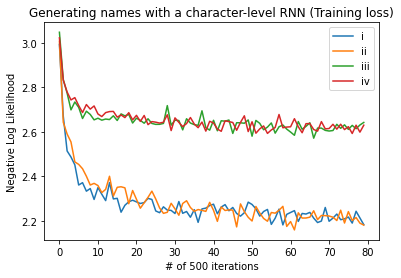

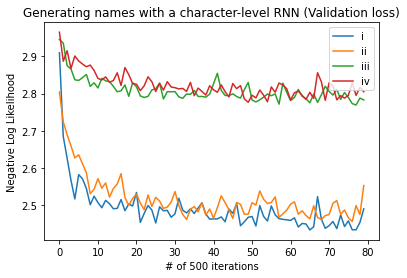

In [23]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_train_losses_i)
plt.plot(all_train_losses_ii)
plt.plot(all_train_losses_iii)
plt.plot(all_train_losses_iv)
plt.title('Generating names with a character-level RNN (Training loss)')
plt.ylabel('Negative Log Likelihood')
plt.xlabel('# of 500 iterations')
plt.legend(['i','ii','iii','iv'], loc='upper right')

plt.figure()
plt.plot(all_validation_losses_i)
plt.plot(all_validation_losses_ii)
plt.plot(all_validation_losses_iii)
plt.plot(all_validation_losses_iv)
plt.title('Generating names with a character-level RNN (Validation loss)')
plt.ylabel('Negative Log Likelihood')
plt.xlabel('# of 500 iterations')
plt.legend(['i','ii','iii','iv'], loc='upper right')

# evaluate on test set and print average test loss
rnn = torch.load('char_rnn_generation_model.pt')
average_test_loss = eval_dataset1(test_data)
print('Average test loss_i: ' + str(average_test_loss))

# evaluate on test set and print average test loss
rnn = torch.load('char_rnn_generation_model2.pt')
average_test_loss = eval_dataset2(test_data)
print('Average test loss_ii: ' + str(average_test_loss))

# evaluate on test set and print average test loss
rnn = torch.load('char_rnn_generation_model3.pt')
average_test_loss = eval_dataset3(test_data)
print('Average test loss_iii: ' + str(average_test_loss))

# evaluate on test set and print average test loss
rnn = torch.load('char_rnn_generation_model4.pt')
average_test_loss = eval_dataset4(test_data)
print('Average test loss_iv: ' + str(average_test_loss))

# **Discussion**

As we move forward from part i to iv we reduce the number of information fed into our RNN. As the results shows, the more we fed information to RNN the more accurate result we get (from case iv to case i). Both training and test loss decreases as we feed more info to the network since we are training our RNN with more data and higher efficiency. This increase of 
information is not so much that leads to overfitting ( we can see the results improving in case i), however, in case i the time of running the code increses so it is a bit more costly as we are dealing with more data entry in our RNN.

Also comparison between case ii and case iii shows that in this model feeding the previous hidden unit and previous character is better than feeding previous hidden unit and category. My understanding of this is that, the previous character changes in every iteration and feeding it to the network is a useful and new information. Category, on the other hand, is a fixed information which is alredy given to model in the first iteration and feeding it in all iterations does not help that much.